### 1. **Setup + Imports Cell**

In [1]:
import os
import sys

# 🔁 Add your project root to Python path
project_root = os.path.abspath("..")  # or "../ProjectName" if nested deeper
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# Now you can import modules from the root directory

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import plotly.graph_objects as go
import plotly.io as pio
import glob
from src.dataloader import get_dataloaders
from src.models.resnet import get_model  # or use build_effnet if swapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

### 2. **Load Latest Model**

In [3]:
def get_latest_model(path="../models", pattern="*.pt"):
    files = glob.glob(os.path.join(path, pattern))
    if not files:
        raise FileNotFoundError(f"No .pt files found in: {os.path.abspath(path)}")
    return max(files, key=os.path.getctime)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = get_latest_model()
model = get_model()
model.load_state_dict(torch.load(model_path))
model.eval().to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 3. **Inference + Accuracy on Test Set**

In [4]:
_, _, test_loader = get_dataloaders()
correct, total = 0, 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model(x)
        preds = torch.argmax(preds, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"🎯 Test Accuracy: {correct/total:.4f}")

🎯 Test Accuracy: 0.9178


### 4. **Confusion Matrix + Save to `reports/`**

In [5]:
def generate_and_save_confusion_matrix(model, dataloader, class_names, save_path="../reports/confusion_matrix.png"):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(DEVICE)
            outputs = model(x)
            predicted = torch.argmax(outputs, dim=1)

            preds.extend(predicted.cpu().tolist())
            targets.extend(y.tolist())

    cm = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Ensure reports directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Plot and save the confusion matrix
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", xticks_rotation=45, values_format='d')
    plt.title("📊 Confusion Matrix")
    plt.savefig(save_path)
    plt.show()

    print(f"✅ Saved confusion matrix to: {save_path}")

In [6]:
# 1. Run predictions over test set
all_preds, all_labels = [], []
class_names = [
    "Bear", "Bird", "Cat", "Cow", "Deer", "Dog", "Dolphin",
    "Elephant", "Giraffe", "Horse", "Kangaroo", "Lion", "Panda",
    "Tiger", "Zebra"
]
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())

# 2. Compute metrics
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, labels=range(len(class_names)), zero_division=0
)

# 3. Build dataframe
results_df = pd.DataFrame({
    "Class": class_names,
    "Images": support,
    "Precision": np.round(precision, 4),
    "Recall": np.round(recall, 4),
    "F1-Score": np.round(f1, 4)
})

# 4. Display it
print("📊 Per-Class Evaluation Metrics")
display(results_df)

# 5. Save to CSV
results_df.to_csv("../reports/per_class_metrics.csv", index=False)


📊 Per-Class Evaluation Metrics


,Class,Images,Precision,Recall,F1-Score
0,Bear,18,1.0000,0.8889,0.9412
1,Bird,21,0.9130,1.0000,0.9545
2,Cat,18,1.0000,0.8333,0.9091
3,Cow,20,0.8182,0.9000,0.8571
4,Deer,19,0.6296,0.8947,0.7391
5,Dog,19,0.8889,0.8421,0.8649
6,Dolphin,19,1.0000,1.0000,1.0000
7,Elephant,20,1.0000,1.0000,1.0000
8,Giraffe,20,0.9000,0.9000,0.9000
9,Horse,20,1.0000,0.8500,0.9189


<Figure size 800x600 with 0 Axes>

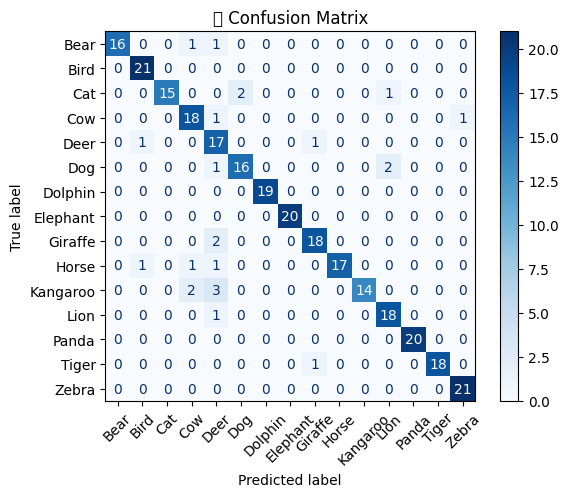

✅ Saved confusion matrix to: ../reports/confusion_matrix.png


In [7]:
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
_, _, test_loader = get_dataloaders()

class_names = [
    "Bear", "Bird", "Cat", "Cow", "Deer", "Dog", "Dolphin",
    "Elephant", "Giraffe", "Horse", "Kangaroo", "Lion", "Panda",
    "Tiger", "Zebra"
]

generate_and_save_confusion_matrix(model, test_loader, class_names)

Creating graph with soothing animation.

In [8]:
import plotly.io as pio

pio.templates["custom_mint"] = go.layout.Template(
    layout=dict(
        font=dict(family="Segoe UI", size=13, color="#333"),
        paper_bgcolor="white",
        plot_bgcolor="white",
        colorway=["#6A5ACD", "#2E8B8B", "#FF6B6B", "#E8C547", "#3CB371"]
    )
)

pio.templates.default = "custom_mint"

In [13]:
# Function to plot accuracy using Plotly

def plot_accuracy_plotly(train_acc, val_acc, save_dir="../reports", filename_prefix="plotly_accuracy"):
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(save_dir, f"{filename_prefix}_{timestamp}.png")

    epochs = list(range(1, len(train_acc) + 1))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs, y=train_acc, mode='lines+markers', name='Train Accuracy'))
    fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines+markers', name='Validation Accuracy'))
    fig.update_layout(
        title="📈 Accuracy per Epoch",
        xaxis_title="Epoch",
        yaxis_title="Accuracy",
        template="plotly_white",
    )

    fig.show()

    try:
        img_bytes = fig.to_image(format="png", scale=3)
        with open(save_path, "wb") as f:
            f.write(img_bytes)
        print(f"✅ Accuracy plot saved to: {save_path}")
    except Exception as e:
        print(f"⚠️ Could not save accuracy plot: {e}")
plot_accuracy_plotly(train_acc, val_acc)


⚠️ Could not save accuracy plot: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome




In [ ]:
# Function to plot classwise metrics using Plotly
import plotly.express as px

def plot_classwise_metrics(df, save_dir="../reports", filename_prefix="plotly_classwise_metrics"):
    import os, datetime
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(save_dir, f"{filename_prefix}_{timestamp}.png")

    fig = px.bar(
        df.melt(id_vars="Class", value_vars=["Precision", "Recall", "F1-Score"]),
        x="Class", y="value", color="variable", barmode="group",
        title="🔍 Per-Class Evaluation Metrics",
    )
    fig.update_layout(yaxis_title="Score", template="plotly_white")
    fig.show()

    try:
        img_bytes = fig.to_image(format="png", scale=3)
        with open(save_path, "wb") as f:
            f.write(img_bytes)
        print(f"✅ Classwise metrics plot saved to: {save_path}")
    except Exception as e:
        print(f"⚠️ Could not save classwise metrics plot: {e}")

plot_classwise_metrics(results_df)


⚠️ Could not save classwise metrics plot: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome




### 5. **Plot Metrics from MLflow**

In [10]:
import mlflow
mlflow.set_tracking_uri("file:../mlruns")

In [11]:
def plot_accuracy(train_acc, val_acc, save_path="../reports/final_accuracy_plot.png"):
    epochs = list(range(1, len(train_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', color='seagreen')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s', color='darkred')

    plt.title("📈 Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
 
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.show()
    print(f"✅ Accuracy plot saved to: {save_path}")


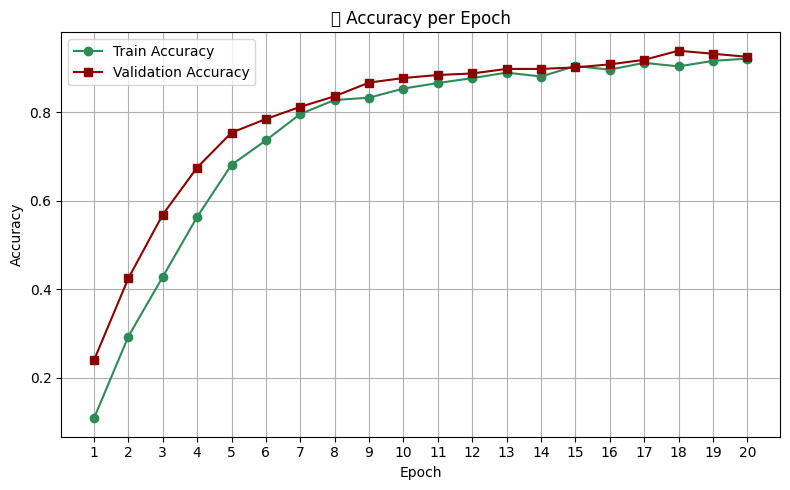

✅ Accuracy plot saved to: ../reports/final_accuracy_plot.png


In [12]:
from mlflow.tracking import MlflowClient
client = MlflowClient()
experiment = client.get_experiment_by_name("animal_classifier_v2")
# run = sorted(client.search_runs(experiment.experiment_id), key=lambda r: r.start_time)[-1]
run = sorted(
    client.search_runs([experiment.experiment_id]),
    key=lambda r: r.info.start_time
)[-1]

run_id = run.info.run_id

train_acc = [m.value for m in client.get_metric_history(run_id, "train_acc")]
val_acc = [m.value for m in client.get_metric_history(run_id, "val_acc")]

plot_accuracy(train_acc, val_acc)

### 6. **Visualize Predictions**

In [14]:
class_names = [
    "Bear", "Bird", "Cat", "Cow", "Deer", "Dog", "Dolphin",
    "Elephant", "Giraffe", "Horse", "Kangaroo", "Lion", "Panda",
    "Tiger", "Zebra"
]

def show_predictions(model, dataloader, num_images=8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 6))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                image_np = images[i].cpu().permute(1, 2, 0).numpy()
                image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # normalize

                plt.subplot(2, int(np.ceil(num_images / 2)), images_shown + 1)
                plt.imshow(image_np)
                plt.title(f"✅ True: {class_names[labels[i]]}\n🔮 Pred: {class_names[preds[i]]}",
                          fontsize=9, color="green" if preds[i] == labels[i] else "red")
                plt.axis("off")
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.tight_layout()
    plt.show()

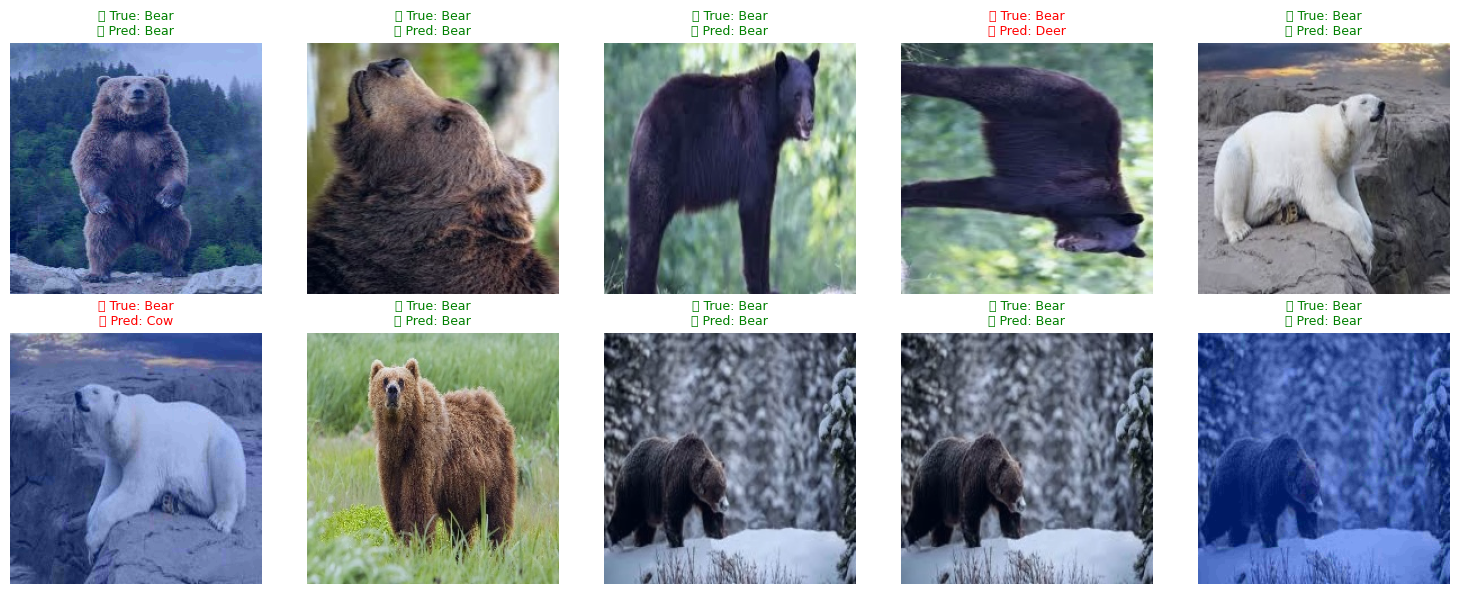

In [15]:
# Load test loader
_, _, test_loader = get_dataloaders()

# Show predictions
show_predictions(model, test_loader, num_images=10)

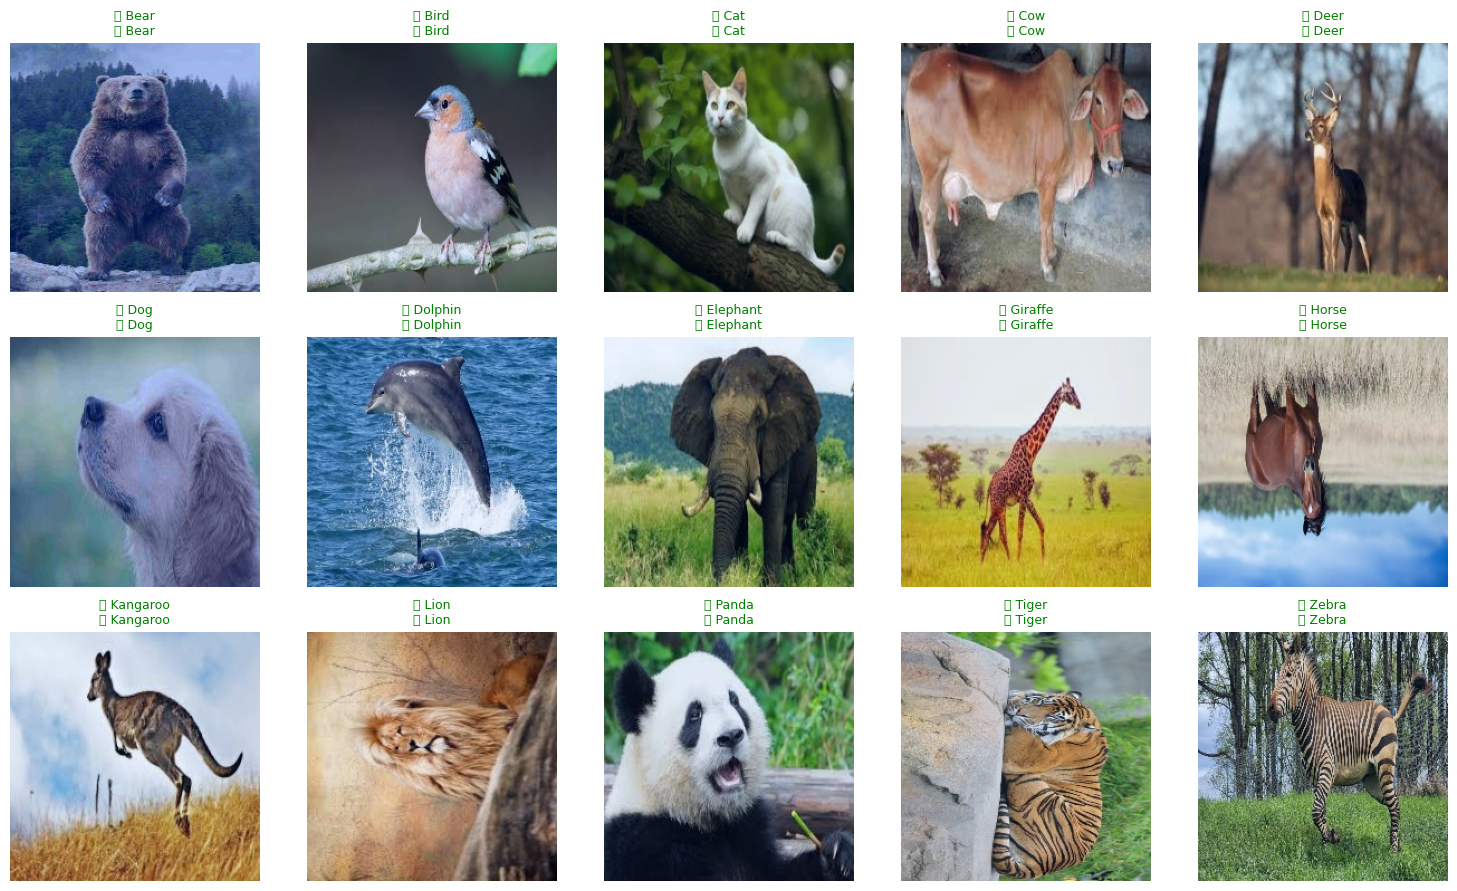

🖼️ Saved prediction preview grid to: ../reports/predictions_per_class.png


In [16]:

def show_predictions_one_per_class(model, dataloader, class_names, save_path="../reports/predictions_per_class.png"):
    model.eval()
    shown_classes = set()
    num_classes = len(class_names)
    rows, cols = 3, 5 if num_classes <= 15 else (int(np.ceil(num_classes / 5)), 5)

    plt.figure(figsize=(cols * 3, rows * 3))

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                true_cls = labels[i].item()
                if true_cls in shown_classes:
                    continue

                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

                idx = len(shown_classes)
                plt.subplot(rows, cols, idx + 1)
                plt.imshow(img_np)
                plt.title(f"✅ {class_names[true_cls]}\n🔮 {class_names[preds[i]]}",
                          color="green" if preds[i] == labels[i] else "red", fontsize=9)
                plt.axis("off")
                shown_classes.add(true_cls)

                if len(shown_classes) == num_classes:
                    break
            if len(shown_classes) == num_classes:
                break

    plt.tight_layout()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"🖼️ Saved prediction preview grid to: {save_path}")
# Show one prediction per class
show_predictions_one_per_class(model, test_loader, class_names)